Cat or Dog Neural Network

In [19]:
#load modules
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import preprocessing
import tensorflow as tf
import os
from PIL import Image
import splitfolders
import matplotlib.pyplot as plt

Image Processing

In [20]:
#goes through each image and checks if it is non-corrupt, deletes if it is corrupted
folder_path = 'PetImages'
extensions = []
for fldr in os.listdir(folder_path):
    sub_folder_path = os.path.join(folder_path, fldr)
    for filee in os.listdir(sub_folder_path):
        file_path = os.path.join(sub_folder_path, filee)
        print('** Path: {}  **'.format(file_path), end="\r", flush=True)
        try:
            im = Image.open(file_path)
            rgb_im = im.convert('RGB')
            if filee.split('.')[1] not in extensions:
                extensions.append(filee.split('.')[1])
        except: 
            os.remove(file_path)

Using the above section of code, cats/666.jpg and dogs/11702.jpg were identified as corrupt and deleted

In [21]:
#splits each folder into .8 training, .1 validation, and .1 testing
splitfolders.ratio("PetImages", output="PetImagesSplit",
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

In [22]:
"""the following function is used to create a data generator that will be used to train the neural network. The data generator will randomly rotate, shift, and zoom the images to create a more robust neural network."""
training_data_generator = ImageDataGenerator(
        #Rescale the image by 1/255 to normalize the pixel values
        rescale=1.0/255,
        # #Randomly increase or decrease the size of the image by up to 20%
        # zoom_range=0.2, 
        # #Randomly rotate the image between -15,15 degrees
        # rotation_range=15, 
        # #Shift the image along its width by up to +/- 5%
        # width_shift_range=0.05, 
        # #Shift the image along its height by up to +/- 5%
        # height_shift_range=0.05 
)

In [23]:
#variables being fed to training data generator
train_directory = "PetImagesSplit/train/" #path to the folder containing the images to train
val_directory = "PetImagesSplit/val/" #path to the folder containing the images to val
test_directory = "PetImagesSplit/test/" #path to the folder containing the images to test
class_mode = "categorical"
color_mode = "rgb" 
target_size = (256, 256) #resizes each image to 256x256
batch_size = 16

In [24]:
training_iterator = training_data_generator.flow_from_directory(train_directory, class_mode =class_mode ,color_mode =color_mode ,target_size = target_size, batch_size = batch_size)

Found 20731 images belonging to 2 classes.


Mode Building

In [25]:
def create_model_base():
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(256, 256, 3)))
    model.add(tf.keras.layers.Conv2D(2, 5, strides=3, activation="relu")) 
    model.add(tf.keras.layers.MaxPooling2D(
        pool_size=(5, 5), strides=(5,5)))
    model.add(tf.keras.layers.Conv2D(4, 3, strides=1, activation="relu")) 
    model.add(tf.keras.layers.MaxPooling2D(
        pool_size=(2,2), strides=(2,2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(2,activation="softmax"))
    return model

create_model_base was a model used to identify pneumonia in grayscale chest images from a lesson I did. Needless to say, the accuracy was no better than chance after 5 epochs. ~600 parameters.

In [26]:
def create_model_1():
    model = tf.keras.Sequential()   
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(256, 256, 3)))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(2,activation="softmax"))
    return model

create_model_base1 was based on Jason Brownlee's claim that stacking convolutional layers add easily understandable complexity, which I felt the model definitely needed considering the lower paramter count and accuracy. ~350k params. The accuraccy ended up being ~.55 at 1 and 2 epochs which indicated to me that the model needed even more complexity

In [27]:
def create_model_2():
    model = tf.keras.Sequential()   
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(256, 256, 3)))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(2,activation="softmax"))
    return model

create_model_complex added an extra layer of convolution and pooling. ~520k params. The added features led to a worse accuraccy of .53-.52 for the first 2 epochs.

In [28]:
def create_model_3():
    model = tf.keras.Sequential()   
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(256, 256, 3)))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(2,activation="softmax"))
    return model

Removing a layer seemed to increase learning. 1st few epochs .6 -> .65 -> .7. Ended at .8 after 10 iterations, logarithmic growth. Best score yet, but needs more tuning. From this image, it is clear that there is a bit of overfitting going on, as the test loss is greater than the actual loss.
For this reason the next iteration will involve some regularization.
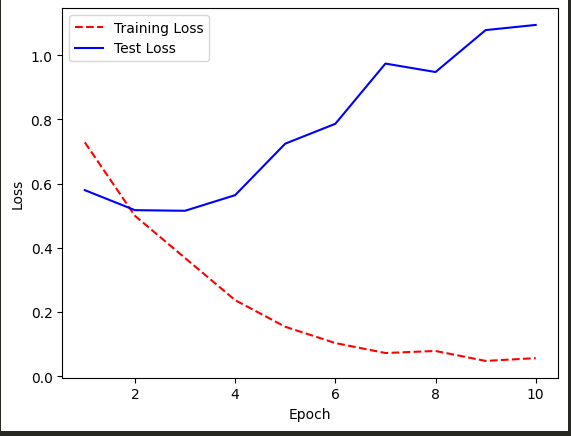


In [29]:
def create_model_4():
    model = tf.keras.Sequential()   
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(256, 256, 3)))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(2,activation="softmax"))
    return model

Immediately, this model looks a lot strong with an accuraccy of .67 -> .8 -> .85 in the first few epochs. The final categorical accuracy ended at .95 at 10 epochs. The model seems to run 3 times as fast as well. While the test loss was more similar to the training loss, there is some improvements to be made with regularization.
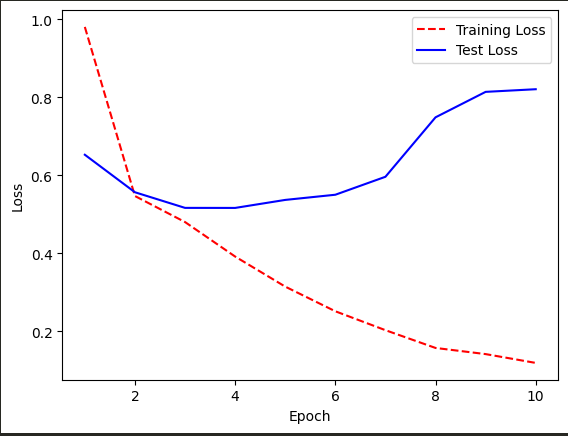

In [30]:
def create_model_5():
    model = tf.keras.Sequential()   
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(256, 256, 3)))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(2,activation="softmax"))
    return model

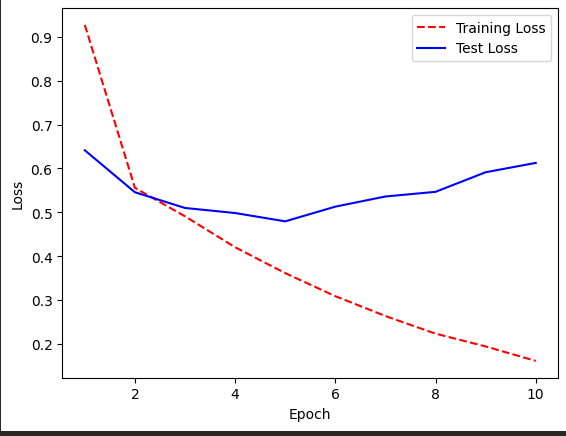
Even less overfitting, while similar accuracy scores. Even faster run times. I'm pretty happy with where it is right now, so I am going to increase the epochs to get a final model.

In [31]:
model = create_model_5()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 64, 64, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 262144)           

In [32]:
#model compilation
#model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.AUC()])

In [33]:
validation_data_generator = ImageDataGenerator( rescale=1./255)
validation_iterator = validation_data_generator.flow_from_directory(val_directory, class_mode =class_mode ,color_mode =color_mode ,target_size = target_size, batch_size = batch_size)
test_data_generator = ImageDataGenerator( rescale=1./255)
test_iterator = validation_data_generator.flow_from_directory(test_directory, class_mode =class_mode ,color_mode =color_mode ,target_size = target_size, batch_size = batch_size)

Found 2907 images belonging to 2 classes.
Found 2906 images belonging to 2 classes.


In [34]:
# model.fit(
#        training_iterator,
#        steps_per_epoch=training_iterator.samples/batch_size,
#        epochs=10,
#        validation_data=validation_iterator,
#        validation_steps=validation_iterator.samples/batch_size)

Epoch 1/30
1295/1295 [==============================] - 28s 22ms/step - loss: 1.2105 - categorical_accuracy: 0.6112 - auc_1: 0.6586 - val_loss: 0.6498 - val_categorical_accuracy: 0.6175 - val_auc_1: 0.6816
Epoch 2/30
1295/1295 [==============================] - 27s 20ms/step - loss: 0.5769 - categorical_accuracy: 0.7006 - auc_1: 0.7724 - val_loss: 0.5766 - val_categorical_accuracy: 0.7079 - val_auc_1: 0.7764
Epoch 3/30
1295/1295 [==============================] - 27s 21ms/step - loss: 0.5042 - categorical_accuracy: 0.7565 - auc_1: 0.8358 - val_loss: 0.5499 - val_categorical_accuracy: 0.7368 - val_auc_1: 0.8051
Epoch 4/30
1295/1295 [==============================] - 27s 21ms/step - loss: 0.4466 - categorical_accuracy: 0.7901 - auc_1: 0.8737 - val_loss: 0.5417 - val_categorical_accuracy: 0.7365 - val_auc_1: 0.8099
Epoch 5/30
1295/1295 [==============================] - 27s 21ms/step - loss: 0.3783 - categorical_accuracy: 0.8305 - auc_1: 0.9123 - val_loss: 0.4753 - val_categorical_accurac

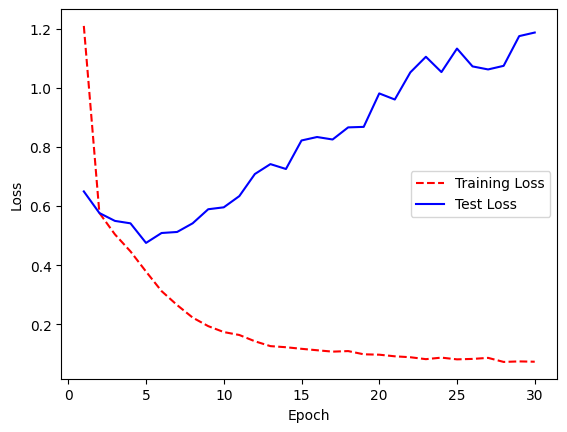

In [35]:
history = model.fit(
       training_iterator,
       steps_per_epoch=training_iterator.samples/batch_size,
       epochs=30  ,
       validation_data=validation_iterator,
       validation_steps=validation_iterator.samples/batch_size)

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [37]:
acc = model.evaluate_generator(test_iterator, steps=len(test_iterator), verbose=0)
print(acc)

[1.1696596145629883, 0.8117687702178955, 0.8690446615219116]


In [75]:
# load and prepare the image
def load_image(filename):
 # load the image
 img = tf.keras.utils.load_img(filename, target_size=(256, 256))
 # convert to array
 img = tf.keras.utils.img_to_array(img)
 # reshape into a single sample with 3 channels
 img = img.reshape(1, 256, 256, 3)
 # center pixel data
 img = img.astype('float32')
 img = img - [123.68, 116.779, 103.939]
 return img

In [79]:
testimg =  r"PetImagesSplit\test\Cat\11703.jpg"
testimg = load_image(testimg)
result = testimg
print(model.predict(result))

[[1. 0.]]


[0. 1.] would refer to a dog. 0 for cat variable 1 for dog varible, while [1. 0.] would refer to a cat